# TFRecord

现在从AlexNet开始,我们处理的数据集不再是简单的小样本数据集,可能一张图片的大小就为$(300,800)$的大小,那么对于一整个训练样本而言,数据量就会变得非常的大,我们也不能简单的使用CPU进行计算.需要开始尝试使用GPU计算(关于更多GPU的搭建内容请看末尾).

在处理大样本训练集而言,我们需要先看看对于**小样本数据**的TFRecord格式.

TFRecord 是谷歌推荐的一种二进制文件格式,理论上它可以保存任何格式的信息.TFRecord 的核心内容在于内部有一系列的 Example,Example 是 [Google Protocol Buffer 协议下的消息体](https://www.ibm.com/developerworks/cn/linux/l-cn-gpb/index.html),实际上Google Protocol Buffer和Json,XML协议都很相似,只不过Google Protocol Buffer是 Google 公司内部的混合语言数据标准,速度非常快,但是没有Json,XML内容覆盖广泛.

> 说的简单一点,也就是说TFRecord就是一种存储数据的文件,Tensorflow通过TFRecord可以快速的读写数据.当然也不是说一定要使用TFRecord,它只是Tensorflow 推荐的一种读写数据集的方式.

> 就当前版本(1.13.1)而言,TFRecord对小样本数据的支持较好,对于大样本而言在多轮写入之后资源会逐渐被耗尽导致数据写入异常缓慢.


那么我们现在来举一个简单的例子,看看TFRecord如何定义和使用.

### [1] Example.

首先我们要了解什么是Example,它很像Json和XML的形式,一个Example可以有多个Features,每个Features里面可以有很多个feature,在feature里面包含了"key-value"的形似,其中key一般为str,value支持三种消息体:

- 1.BytesList

- 2.FloatList

- 3.Int64List

- 三者全部为列表格式.

举个例子,一个 BytesList 可以存储 Byte 数组(列表),因此像字符串、图片、视频等等都可以容纳进去,所以 TFRecord 可以存储几乎任何格式的信息.

比如我们定义如下的Example(以一张名为):

```protocolbuf
Example Message{
    Ffeatures{
        feature{
            key:"name"
            value:{
                bytes_list:{
                    value:"cat"
                }
            }
        }
        feature{
            key:"shape"
            value:{
                int64_list:{
                    value:1266
                    value:1900
                    value:3
                }
            }
        }
        feature{
            key:"data"
            value:{
                bytes_list:{
                    value:0xbe
                    value:0xb2
                    ...
                    value:0x3
                }
            }
        }
    }
}

```

Example定义了一个Features和三个feature:

第一个feature: key为"name",value是一个bytes_list,其中的内容为"cat",需要注意的是,这里的cat需要转换成bytes的格式.

第二个feature: key为"shape",value是一个int64_list,其中的内容为"1266,1900,3",实际上就是图片的三个形状数.

第三个feature: key为"data",value是一个bytes_list,其中的内容为"图片的二进制内容",需要注意的是,这里的"内容"也要转换成bytes的格式.

### [2] Write Picture

下面使用代码来实现如何将图片写入TFRecord.

对于图片:

<img src="cat.jpg" hight=500 width=500>

In [3]:
def write_test(input,output):
    """
    使用TFRecordWriter 将信息写入 TFRecord文件,
    需要注意的是:
    生成的TFRecord文件往往要比图片原文件要大,因为我们的图片往往都是通过压缩的
    
    Arguments:
    ---------
       input: 输入图片的路径.
       output: 输出TFRecord文件的路径.
        
    """
    write = tf.python_io.TFRecordWriter(output)
    # 读取图片并解码
    image = tf.read_file(input)
    image = tf.image.decode_jpeg(image) # 除了jpeg的格式还有png的格式

    with tf.Session() as sess:
        image = sess.run(image)
        shape = image.shape
        print('The Orginal picture shape is:{}'.format(shape))
        # 将图片转换成string,转换成bytes格式也可以,转换后的文件大小相差不大
        image_data = image.tostring()
        
        # 因为下面我们需要将name这个变量存储为beytes_list格式,所以我们这里需要更改为bytes类型
        name = bytes('cat',encoding='utf8')

        # 创建Example对象,并将 Feature 一一对应填充进去.
        example = tf.train.Example(features=tf.train.Features(feature={
            'name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[name])),
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=list(shape))),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data]))
        }))

        # 将Example实例化成string类型后才可以写入
        write.write(example.SerializeToString())

        write.close()

上面代码中的注释已经很详细了,这里稍微提一点比较重要的地方:

> 1.我们需要使用```tf.python_io.TFRecordWriter(output)```来帮助我们将图片信息写入TFRecord文件.

> 2.使用```tf.read_file(input)```读取图片之后必须要decode,另外除了jpeg的格式还有png的格式,如果你的训练图片既有jpeg/jpg又有png的图片,那么你需要自定义一个函数将图片童统一转换为一种格式.

> 3.由于保存图片内容是Bytes_list的形似,所以我们必须要将其转换成bytes的格式或者string的格式```image.tostring()```.两者转换后的文件大小相差无几.

> 4.在写入example的时候,必须要value必须要采用list的形似.

> 5.最后example必须要string序列化才能写入```example.SerializeToString()```


我们来看看转换后的结果:

![](../../../../../picture/197.png)

可以看到写入到TFRecord后的文件"cat.tfrecord"文件要比原来的"cat.jpg"文件大许多,这是正常的,因为图片通常是通过压缩后显示的.

### [3] Read TFRecord

现在我们来看看如何查看TFRecord中的内容.

In [18]:
def _parse_record(example_proto):
    features = {
        'name': tf.FixedLenFeature((),tf.string), # FixedLenFeature:获取的是固定长度,如果长度元素为1,则可以填写为()
        'shape': tf.FixedLenFeature([3],tf.int64), # 由于shape list的长度为3,所以这里需要指定固定长度为3.
        'data':tf.FixedLenFeature((),tf.string)
    }
    
    # 依照定义的features获取TFRecord中相应一个example的内容.
    parsed_features = tf.parse_single_example(example_proto,features=features)

    return parsed_features


def read_test(input_file):
    import numpy as np
    import matplotlib.pyplot as plt
    # 读取tfrecord文件
    dataset = tf.data.TFRecordDataset(input_file)
    dataset = dataset.map(_parse_record) # 使用map函数一一作用与_parse_record
    iterator = dataset.make_one_shot_iterator()

    # 依据官方提示,如果我们迭代的次数过多,我们需要先定义一个先行get_next的方式,否则速度会越来越慢,最终导致资源耗尽
    example = iterator.get_next() 

    with tf.Session() as sess:
        features = sess.run(example)
        name = features['name'].decode('utf8')
        n_h,n_w,n_c = features['shape']
        print('The picture name is:{}'.format(name))
        print('The picture shape is:{}'.format((n_h,n_w,n_c)))

        data = features['data']
        
        # 需要使用numpy将读出来的data更改为数组,才能展示图片,并且依据numpy提示,不能使用np.fromstring,其很不稳定.
        img = np.frombuffer(data,np.uint8)
        img = np.reshape(img,(n_h,n_w,n_c))

        plt.imshow(img)

        # 将data重新编码写入本地
        img = tf.image.encode_jpeg(img)
        tf.gfile.GFile('cat_encode.jpg','wb').write(img.eval())

上面的注释也比较详细了,下面来阐述一些比较重要的地方:

> 1. 我们需要借助```tf.data.TFRecordDataset(input_file)```来读取TFRecord文件.

> 2. 需要定义一个先行函数```_parse_record```用于获取一个Example中的哪些内容.
    - ```FixedLenFeature```是用于读取feature,如果value里面的list长度是固定为1,那么第一个参数可以只填写```()```,否则需要定义长度,应为```FixedLenFeature```只适用于读取固定长度,如果图片大小不确定(每张大小都不一样),那么我们可以使用[tf.VarLenFeature()](https://www.tensorflow.org/api_docs/python/tf/io/parse_example)来读取value中的list长度可变的情况.

> 3. 使用```map(_parse_record)```将读取出来的Example分别map于先行函数.

> 4. 最后使用```make_one_shot_iterator()```迭代器一个一个拿出内容.
    - 这里需要注意的是,如果样本数量过多,需要先行定义一个迭代变量```example = iterator.get_next() ```,否则TF会警告资源耗尽.

> 5. 迭代出来的内容如果是bytes类型需要decode.

> 6. 如果要查看图片内容需要将其转换为ndarray类型,需要注意的是要使用```np.frombuffer(data,np.uint8)```,使用```np.fromstring```Numpy 会告知很不稳定.

The picture name is:cat
The picture shape is:(1266, 1900, 3)


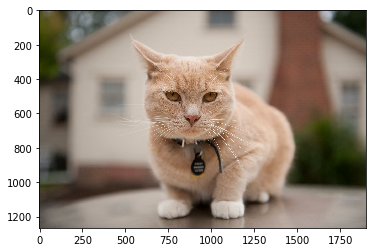

In [19]:
input_file = 'cat.tfrecord'
read_test(input_file)

接着我们来看看读出来图片之后再次转存的文件大小:

![](../../../../../picture/198.png)

可以看到转存之后的大小为"258K"也是要比原图"134K"要大的,虽然整体占用内容大,但是使用TFRecord的读取效率会更加高效,而且结合TF的Dataset可以更高效的处理图片的读取.

以上就是简单版本的TFRecord操作.

### [4] GPU

由于现在训练的样本不再是简单的小样本数据集,所以我们需要搭建GPU,个人建议使用Google Cloud(墙),新用户会给予300美刀和一年的免费使用时间.

基于cs231n的搭建地址:[gcloud](https://github.com/cs231n/gcloud),最后提交时间为:**Latest commit 775ebbc  on Apr 16**

需要注意的是:

- 教程中申请的GPU区域需要选择[GPUs(all regions)](https://stackoverflow.com/questions/53415180/gcp-error-quota-gpus-all-regions-exceeded-limit-0-0-globally)

- 看好自己的本地时间和VM实例的当地时间,申请GPU配额的时候最好在VM实例工作人员的当地上班时间,这样的分配速度会快一些.我测试的时间为20分钟得到1块GPU的配额.

在教程中会有以下提醒:

<img src="../../../../../picture/199.png" height=500 width=500>



这里我们依然选择Tensorflow 1.13,另外在**Verification**步骤需要注意不要尝试运行```python test_tf.py```,会安装Tensorflow 2.0,就目前而言2.0版本是alpha版本,所以我们暂时先不要使用2.0版本.

还需要注意的是:VM实例中的Jupyter-notebook的版本比较老(虽然我们一般不会在炼丹炉内使用jupyter训练模型),我们需要手动更新:

```pip3 install --upgrade jupyter```.

另外不要更新pip,否则pip3会无法使用,如果你不小心更新了,可以使用```python3 -m pip install ```来代替```pip3 install ```.

最后安装完使用gcloud工具进入之后会有如下显示:


![](../../../../../picture/200.png)

可以看到tf-gpu的版本是1.13.另外如果你需要更换gpu的版本,切记一定要找到对应的CUDA版本.

GOOD LUCK~~